<a href="https://colab.research.google.com/github/malloyca/CSC581B/blob/main/Final%20Project/resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC581B - Deep Learning for Image Classification
# Final Project: ResNet

In [1]:
# imports
import torch
from torch import nn
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision.datasets import CIFAR100
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import copy
import numpy as np
import random


Set up data augmentation transforms

In [2]:
# data augmentation transforms
data_augmentation_transform = transforms.Compose([
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.RandomRotation(degrees=30),
  transforms.RandomCrop(32, padding=2),
  transforms.ColorJitter(brightness=0.25, contrast=0.5, saturation=0.25, hue = 0.15),
  transforms.RandomGrayscale(p=0.2),
  transforms.ToTensor(),
  transforms.Normalize(
      mean = [0.5071, 0.4867, 0.4408],
      std = [0.2675, 0.2565, 0.2761]
  ),
  transforms.RandomErasing(p=.35),
])

In [3]:
# non-augmentation transform (with data normalization)
normalize_transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(
      mean = [0.5071, 0.4867, 0.4408],
      std = [0.2675, 0.2565, 0.2761]
  )
])

In [4]:
# Load the training data (CIFAR10 to start)
training_data_with_augmentation = CIFAR100(
    root = "data",
    train = True,
    download = True,
    transform = data_augmentation_transform,
)

training_data_without_augmentation = CIFAR100(
    root = "data",
    train = True,
    download = True,
    transform = normalize_transform,
)

# this is necessary to prevent the data augmentation transforms from being applied to the validation set
validation_data = CIFAR100(
    root = "data",
    train = True,
    download = True,
    transform = normalize_transform,
)

# Load the test data
test_data = CIFAR100(
    root = "data",
    train = False,
    download = True,
    transform = transforms.ToTensor()
)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
training_targets = training_data_with_augmentation.targets

In [6]:
train_split_index, valid_split_index = train_test_split(
    np.arange(len(training_targets)), test_size=0.2, stratify=training_targets
)

In [7]:
batch_size = 100

In [8]:
# Create data loaders
train_augmentation_dataloader = DataLoader(training_data_with_augmentation, batch_size=batch_size,
                              sampler=SubsetRandomSampler(train_split_index))
train_no_augmentation_dataloader = DataLoader(training_data_without_augmentation, batch_size=batch_size,
                              sampler=SubsetRandomSampler(train_split_index))
valid_dataloader = DataLoader(validation_data, batch_size=batch_size,
                              sampler=SubsetRandomSampler(valid_split_index))
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [9]:
train_status = True

In [10]:
if not train_status:
  # Check that it is splitting the data properly
  train_length = 0
  for _, y in train_augmentation_dataloader:
    train_length += len(y)
  print(f"Length of training (augmentation) split: {train_length}")

  train_aug_length = 0
  for _, y in train_no_augmentation_dataloader:
    train_aug_length += len(y)
  print(f"Length of training (no augmentation) split: {train_aug_length}")

  valid_length = 0
  for _, y in valid_dataloader:
    valid_length += len(y)
  print(f"Length of validation split: {valid_length}")

  test_length = 0
  for _, y in test_dataloader:
    test_length += len(y)
  print(f"Length of test split: {test_length}")

In [11]:
if not train_status:
  # Check that there are 100 instances of a random class in the validation set
  count = 0
  test_class = random.randint(0,99)
  for _, y in valid_dataloader:
    for target in y:
      if int(target.numpy()) == test_class:
        count += 1

  print(count)

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Build ResNet for CIFAR100

This is based on section 4.2 of the ResNet paper.

The first layer is $3 \times 3$ convolutions. Then they use a stack of $6n$ layers with $3\times3$ convolutions on the feature maps of sizes $\{32,16,8\}$ respectively with $2n$ layers for each feature map size.

The first residual block of each stack (except the first) downsamples by setting the stride to 2.

In [13]:
# Define the ResNet Block
class ResidualBlock(nn.Module):
  '''
  Class for building the ResNet blocks. The architecture here follows the
  specifications from section 4.2 of the ResNet paper.
  '''
  def __init__(
      self,
      input_channels,
      output_channels,
      stride
  ):
    super(ResidualBlock, self).__init__()
    self.block = nn.Sequential(
        nn.Conv2d(input_channels, output_channels, kernel_size=3, stride=stride, padding=1),
        nn.BatchNorm2d(output_channels),
        nn.ReLU(),
        nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(output_channels)
    )
    self.relu = nn.ReLU()
    self.identity = nn.Sequential()
    if stride == 2:
      self.identity = nn.Sequential(
          Identity(output_channels - input_channels)
      )



  # forward propagation
  def forward(self, x):
    # residual block: y = F(x, w) + x
    out = self.block(x)
    out += self.identity(x)
    out = self.relu(out)
    return out

In [14]:
class Identity(nn.Module):
  '''
  This is an awkward class required to allow me to use nn.functional.pad inside of a squential block in another nn.Module class.
  '''
  def __init__(self,padding):
    super(Identity, self).__init__()
    self.identity = nn.functional.pad
    self.padding = padding


  def forward(self, x):
    #print("Dim going into identity:", list(x.size()))
    x = self.identity(x[:,:,::2,::2], pad=(0,0,0,0,0,self.padding))
    #print("Dim coming out of identity:", list(x.size()))
    return x

In [15]:
# This is based on section 4.2 of the ResNet paper
# number of filters is {16, 32, 64} for the three stacks
class ResNet(nn.Module):
  def __init__(
      self,
      block,
      num_blocks,
      name = 'ResNet',
  ):
    super(ResNet, self).__init__()
    self.num_filters = [16, 32, 64]
    self.name = name

    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(16)
    self.relu = nn.ReLU()
    self.stack1 = self.build_residual_block(block, self.num_filters[0], num_blocks[0], first_stride=1)
    self.stack2 = self.build_residual_block(block, self.num_filters[1], num_blocks[1], first_stride=2) # set first stride to 2 to downsample
    self.stack3 = self.build_residual_block(block, self.num_filters[2], num_blocks[2], first_stride=2)

    self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
    self.flatten = nn.Flatten()
    self.linear = nn.Linear(64, 100)


  def build_residual_block(self, block, num_filters, num_blocks, first_stride):
    strides = [first_stride]
    layers = []
    for _ in range(num_blocks-1):
      strides.append(1)
    for stride in strides:
      if stride == 2:
        layers.append(block(
            input_channels=num_filters//2,
            output_channels=num_filters,
            stride=stride,
        ))
      else:
        layers.append(block(
            input_channels=num_filters,
            output_channels=num_filters,
            stride=stride,
        ))
    return nn.Sequential(*layers)


  def forward(self, x):
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)
    #print("Dim going into stack1:", list(out.size()))
    out = self.stack1(out)
    #print("Dim going into stack2:", list(out.size()))
    out = self.stack2(out)
    #print("Dim going into stack3:", list(out.size()))
    out = self.stack3(out)
    #print("Dim going into linear:", list(out.size()))
    out = self.avg_pool(out)
    out = self.flatten(out)
    out = self.linear(out)
    return out

In [20]:
if not train_status:
  def resnet_test():
    return ResNet(ResidualBlock, [5, 5, 5], name='test')
  model = resnet_test().to(device)
  model

In [16]:
def resnet20():
  return ResNet(ResidualBlock, [3, 3, 3], name='resnet20')

In [17]:
def resnet32():
  return ResNet(ResidualBlock, [5, 5, 5], name='resnet32')

In [27]:
def resnet44():
  return ResNet(ResidualBlock, [7, 7, 7], name='resnet44')

# Training setup

In [21]:
# Training function
def train(dataloader, batch_size, model, loss_fn, optimizer):
  num_batches = len(dataloader)
  size = num_batches * batch_size
  model.train()
  train_loss, num_correct = 0, 0
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # Compute prediction error
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track train_loss and accuracy
    train_loss += loss.item()
    num_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

  train_loss /= num_batches
  accuracy = num_correct / size
  return train_loss, accuracy

In [22]:
# Validation function
def validation(dataloader, batch_size, model, loss_fn):
  num_batches = len(dataloader)
  size = num_batches * batch_size
  model.eval()
  val_loss, num_correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      val_loss += loss_fn(pred, y).item()
      num_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  val_loss /= num_batches
  accuracy = num_correct / size
  print(f"Validation Error: \n Validation accuracy: {(100 * accuracy):>0.1f}%, Validation loss: {val_loss:>8f} \n")
  return val_loss, accuracy

In [23]:
# Test function
def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
  return test_loss

In [24]:
def training_loop(n_epochs, model, train_data, valid_data, batch_size,
                  loss_function, optimizer, scheduler=None,
                  early_stopping=False, patience=10):
  current_epoch = 0
  best_epoch = 0
  best_loss = float('inf')
  patience_counter = 0

  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []

  for e in range(n_epochs):
    print(f"\nEpoch {e+1}\n----------------------------")
    # Iterate epoch counter
    current_epoch += 1

    train_loss, train_accuracy = train(train_data, batch_size, model, loss_function, optimizer)
    val_loss, val_accuracy = validation(valid_data, batch_size, model, loss_function)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Iterate scheduler (this is set up for ReduceLROnPlateau)
    if scheduler is not None:
      scheduler.step(val_loss)

    # If early_stopping check test_loss
    if early_stopping:
      # case: test loss beats the current best loss
      if val_loss < best_loss:
        # store loss
        best_loss = val_loss

        # reset patience counter
        patience_counter = 0

        # store model and epoch number
        print("Storing new best model.")
        best_model_state_dict = copy.deepcopy(model.state_dict)
        best_epoch = current_epoch

      # Case: patience limit not yet reached => iterate patience counter
      elif patience_counter < patience - 1:
        patience_counter += 1
        print(f"Patience count: {patience_counter}")

      # Case: patience limit reached
      else:
        print("Finished due to early stopping.")
        print(f"Saving best model: {model.name}_epoch-{best_epoch:03d}")
        torch.save(best_model_state_dict, f'{model.name}_epoch-{best_epoch:03d}')
        break

  # If we get here, we did not stop early - save best model
  if early_stopping:
    print(f"Saving best model: {model.name}_epoch-{best_epoch:03d}")
    torch.save(best_model_state_dict, f'{model.name}_epoch-{best_epoch:03d}')
  else:
    print()

  return train_losses, train_accuracies, val_losses, val_accuracies

# Training

In [58]:
n_epochs = 100

In [59]:
model_20 = resnet20().to(device)
num_param = sum(p.numel() for p in model_20.parameters())
print(f"Total number of parameters for ResNet20: {num_param:,}")

model_32 = resnet32().to(device)
num_param = sum(p.numel() for p in model_32.parameters())
print(f"Total number of parameters for ResNet32: {num_param:,}")

model_44 = resnet44().to(device)
num_param = sum(p.numel() for p in model_44.parameters())
print(f"Total number of parameters for ResNet44: {num_param:,}")

Total number of parameters for ResNet20: 276,260
Total number of parameters for ResNet32: 471,140
Total number of parameters for ResNet44: 666,020


In [60]:
model_20_aug = resnet20().to(device)
num_param = sum(p.numel() for p in model_20_aug.parameters())
print(f"Total number of parameters for ResNet20: {num_param:,}")

model_32_aug = resnet32().to(device)
num_param = sum(p.numel() for p in model_32_aug.parameters())
print(f"Total number of parameters for ResNet32: {num_param:,}")

model_44_aug = resnet44().to(device)
num_param = sum(p.numel() for p in model_44_aug.parameters())
print(f"Total number of parameters for ResNet44: {num_param:,}")

Total number of parameters for ResNet20: 276,260
Total number of parameters for ResNet32: 471,140
Total number of parameters for ResNet44: 666,020


In [61]:
# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer_20 = torch.optim.Adam(model_20.parameters(), lr=1e-3)
optimizer_20_aug = torch.optim.Adam(model_20_aug.parameters(), lr=1e-3)
optimizer_32 = torch.optim.Adam(model_32.parameters(), lr=1e-3)
optimizer_32_aug = torch.optim.Adam(model_32_aug.parameters(), lr=1e-3)
optimizer_44 = torch.optim.Adam(model_44.parameters(), lr=1e-3)
optimizer_44_aug = torch.optim.Adam(model_44_aug.parameters(), lr=1e-3)

# LR scheduling
scheduler_20 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer_20, mode='min', patience=5)
scheduler_20_aug = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer_20_aug, mode='min', patience=5)
scheduler_32 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer_32, mode='min', patience=5)
scheduler_32_aug = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer_32_aug, mode='min', patience=5)
scheduler_44 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer_44, mode='min', patience=5)
scheduler_44_aug = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer_44_aug, mode='min', patience=5)

In [62]:
train_loss_20, train_accuracy_20, val_loss_20, val_accuracy_20 = training_loop(n_epochs, model_20, train_no_augmentation_dataloader, valid_dataloader, batch_size,
              loss_fn, optimizer_20, scheduler_20, early_stopping=True, patience=20)


Epoch 1
----------------------------
loss: 4.827048 [    0/40000]
loss: 4.010435 [10000/40000]
loss: 3.687391 [20000/40000]
loss: 3.893294 [30000/40000]
Validation Error: 
 Validation accuracy: 14.4%, Validation loss: 3.523175 

Storing new best model.

Epoch 2
----------------------------
loss: 3.476431 [    0/40000]
loss: 3.118614 [10000/40000]
loss: 2.899387 [20000/40000]
loss: 2.788997 [30000/40000]
Validation Error: 
 Validation accuracy: 23.7%, Validation loss: 2.977359 

Storing new best model.

Epoch 3
----------------------------
loss: 2.779550 [    0/40000]
loss: 2.653886 [10000/40000]
loss: 2.553008 [20000/40000]
loss: 2.787303 [30000/40000]
Validation Error: 
 Validation accuracy: 29.0%, Validation loss: 2.744954 

Storing new best model.

Epoch 4
----------------------------
loss: 2.864907 [    0/40000]
loss: 2.382596 [10000/40000]
loss: 2.281186 [20000/40000]
loss: 2.371358 [30000/40000]
Validation Error: 
 Validation accuracy: 34.3%, Validation loss: 2.502522 

Storing 

### LR results
- `1e-1` => 10.4% / 3.807546
- `5e-2` => 16.3% / 3.452366
- `1e-2` => 22.5% / 3.170802
- `5e-3` => 28.6% / 2.796356
- `1e-3` => 28.6% / 2.778201

<function matplotlib.pyplot.show>

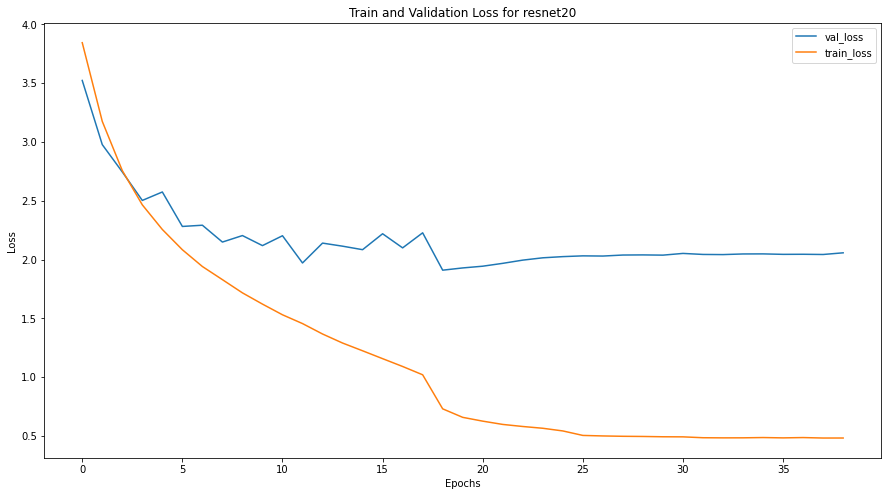

In [63]:
plt.figure(figsize=(15,8))
plt.title(f"Train and Validation Loss for {model_20.name}")
plt.plot(val_loss_20, label="val_loss")
plt.plot(train_loss_20, label="train_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show

<function matplotlib.pyplot.show>

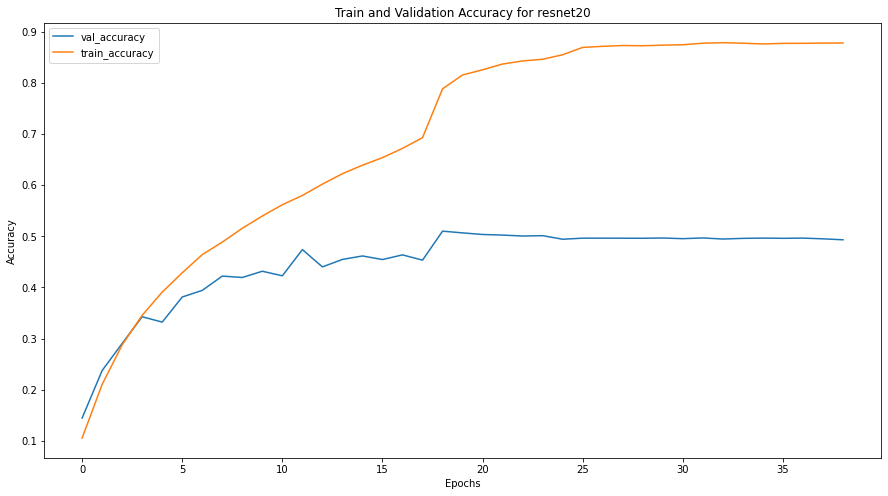

In [64]:
plt.figure(figsize=(15,8))
plt.title(f"Train and Validation Accuracy for {model_20.name}")
plt.plot(val_accuracy_20, label="val_accuracy")
plt.plot(train_accuracy_20, label="train_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show

In [ ]:
train_loss_20_aug, train_accuracy_20_aug, val_loss_20_aug, val_accuracy_20_aug = training_loop(n_epochs, model_20_aug, train_augmentation_dataloader, valid_dataloader, batch_size,
              loss_fn, optimizer_20_aug, scheduler_20_aug, early_stopping=True, patience=20)

In [ ]:
plt.figure(figsize=(15,8))
plt.title(f"Train and Validation Loss for {model_20_aug.name}")
plt.plot(val_loss_20_aug, label="val_loss")
plt.plot(train_loss_20_aug, label="train_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show

In [ ]:
plt.figure(figsize=(15,8))
plt.title(f"Train and Validation Accuracy for {model_20_aug.name}")
plt.plot(val_accuracy_20_aug, label="val_accuracy")
plt.plot(train_accuracy_20_aug, label="train_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show